In [1]:
#-------------------------------------------------------------------------------
# Name:        pattern Recognition Technique
# Purpose:
#
# Author:      Wenshuai Ye
#
# Created:     12/04/2015
# Copyright:   (c) Superman 2015
# Licence:     <your licence>
#-------------------------------------------------------------------------------
from processData import processData
import numpy as np
import pandas as pd
import scipy as sp
import sqlite3
import time
import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from scipy.stats import norm

class PatternRecognition:
    def __init__(self, filename, tablename, intervals, obsMax = 15, split = True, extractTime = True):
        process = processData()
        self.data = process.getData(filename, tablename, intervals, obsMax, split, extractTime)
        self.patternAr = {}
        self.testLine = []
        self.avgLine = []
        #self.testLine = (np.array(self.data[0]['price'])+np.array(self.data[1]['price']))/2
        #self.avgLine = (np.array(self.data[0]['price'])+np.array(self.data[1]['price']))/2

    def vecpercentChange(self, eachPattern, patForRec):
        return np.multiply(patForRec - eachPattern, 1./eachPattern) * 100.
    
    def percentChange(self, startPoint, currentPoint):
        return (float(currentPoint) - startPoint)/startPoint * 100.

    def patternStorage(self, patternLength):
        patStartTime = time.time()

        x = len(self.avgLine) - patternLength

        y = patternLength + 1

        while y < x:
            pattern = [self.percentChange(self.avgLine[y], self.avgLine[y - (patternLength + 1) + i]) 
                       for i in xrange(1, patternLength + 1)]

            outcomeRange = self.avgLine[y+1:y+2]
            currentPoint = self.avgLine[y]

            try:
                if len(outcomeRange) != 0:
                    avgOutcome = np.mean(outcomeRange)
                else:
                    avgOutcome = -100
                
            except Exception, e:
                print str(e)
                avgOutcome=0


            futureOutcome = self.percentChange(currentPoint, avgOutcome)
            self.patternAr[tuple(pattern)] = futureOutcome
            y += 1

        patEndTime = time.time()
        print len(self.patternAr)
        print "Pattern storage took:", patEndTime - patStartTime, " seconds"

    def currentRecognition(self, startIndex, patternLength):
        patForRec = [self.percentChange(self.testLine[-startIndex],
                                           self.testLine[-startIndex+i]) for i in xrange(1, patternLength+1)]

        return patForRec

    def simPatternRecognition(self, threshold, patForRec):
        #plt.figure()
        #Use similarity to find patterns
        i = 0
    
        #plt.plot(np.arange(0,len(patForRec)), patForRec)

        predictions = []
        patterns = np.array(list(self.patternAr.keys()))
        patForRec = np.array(patForRec)
        howSim = (sum(100 - abs(self.vecpercentChange(patterns, patForRec)).T))/len(patForRec)
        qualified = [i for i in xrange(len(howSim)) if howSim[i] > threshold and howSim[i] < 100]
        predictions = np.zeros(len(qualified))
        #plt.plot(patForRec)
        for i in xrange(len(qualified)):
            idx = qualified[i]
            pattern = patterns[idx]
            predictions[i] = self.patternAr[tuple(pattern)]
            #plt.plot(pattern)
        #plt.plot([35 for i in xrange(len(predictions))], predictions, marker = 'o')
        #plt.show()
        '''
        for eachPattern in self.patternAr:
            eachPattern = np.array(eachPattern)
            patForRec = np.array(patForRec)
            howSim = (-sum(abs(percentChange(eachPattern, patForRec))) + len(patForRec)*100)/len(patForRec)
            if howSim > threshold and howSim < 100:
                
                print "##########################"
                print "##########################"
                
                #plt.plot(np.arange(0,len(patForRec)), eachPattern)
                #plt.scatter([65],self.performanceAr[patdex],s=60)
                if self.patternAr[eachPattern] != -100.0:
                    predictions.append(self.patternAr[eachPattern])
                
                print patForRec
                print "=========================="
                print "=========================="
                print eachPattern
                print "--------------------------"
                print "predicted outcome", performanceAr[patdex]
                print "##########################"
                print "##########################"
                
        
        #plt.grid(True)
        #plt.xlim([0,60])
        #plt.show()
        '''
        return predictions


In [2]:
p = PatternRecognition('okcoin.rdb','okcoin_ob', intervals = 200, obsMax = 1)

In [214]:
pattern = p.currentRecognition(31, 30)

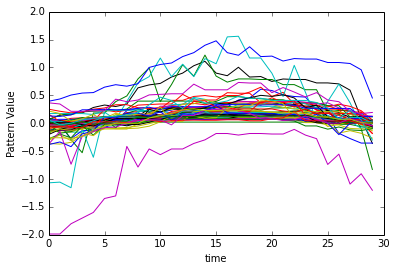

In [83]:
from scipy.stats import spearmanr
plt.plot(pattern)
for key in p.patternAr:
    if np.corrcoef(pattern, list(key))[0,1] > 0.8:
        plt.plot(list(key))
plt.xlabel("time")
plt.ylabel("Pattern Value")
plt.show()

In [5]:
def patternTrade(shortSell = False, simiScore = 60, ci = True):
    direction = []
    share = 0
    sellStk = []
    counter = 0.
    total = 0.
    for start in xrange(buyTest.shape[0]):
        idx = start
        pattern = p.currentRecognition(start, 30)
        prediction = p.simPatternRecognition(simiScore, pattern)
        threshold = 0
        if start % 500 == 0: print "Finish " + str(start) + "th iteration."
        if len(prediction) != 0:
            if ci:
                threshold = -np.mean(prediction) / (np.std(prediction)/np.sqrt(len(prediction)))
                threshold = norm.cdf(threshold)
                if threshold > 0.75: 
                    direction.append(1)
                    continue
                elif threshold < 0.25: 
                    direction.append(-1)
                    continue
            else:
                if np.median(prediction) > 0.05:
                    direction.append(1)
                    continue
                elif np.median(prediction) < -0.05:
                    direction.append(-1)
                    continue
            
        direction.append(0)
    return direction

In [9]:

def simple_trade(buyPrice,sellPrice,lastBuyPrice,lastSellPrice,predictionDirB,predictionDirS):
    bank1 = 10**3
    assets1 = 0

    bankTracker1 = [bank1]
    assetTracker1 = [0]

    betSize = .1
    
    for ii in range(30,len(buyPrice)-1):

        buyP1 = buyPrice[ii]
        sellP1 = sellPrice[ii]
        i = ii - 30
        if predictionDirS[i] > 0: # buy
            bank1 = bank1 - betSize*sellP1
            assets1 = assets1 + betSize
        if predictionDirB[i] < 0: # sell
            bank1 = bank1 + betSize*buyP1
            assets1 = assets1 - betSize
            
        bankTracker1.append(bank1)
        assetTracker1.append(assets1)
        
    # close position at end
    if assets1 > 0: # sell
        bank1 = bank1 + assets1*lastBuyPrice
        assets1 = 0
    if assets1 < 0: # buy
        bank1 = bank1 + assets1*lastSellPrice
        assets1 = 0
        
    bankTracker1.append(bank1)
    assetTracker1.append(assets1)

    bankTracker1 = np.array(bankTracker1)
    assetTracker1 = np.array(assetTracker1)
    profit = bankTracker1[-1] - bankTracker1[0]
    
    return profit, bankTracker1, assetTracker1

In [13]:
def compute_accuracy(priceList, direction):
    trueDir = []
    for i in xrange(len(priceList)-1):
        if priceList[i] < priceList[i+1]:
            trueDir.append(1)
        elif priceList[i] > priceList[i+1]:
            trueDir.append(-1)
        else:
            trueDir.append(0)
    counter = 0.
    accurate = 0.
    for i in xrange(len(direction)):
        if direction[i] != 0:
            counter += 1.
            if direction[i] == trueDir[i]:
                accurate += 1.
    return accurate / counter

### Period 1

In [42]:
import datetime as dt
buyTest = p.data[0][(p.data[0]['timestamp'] >= dt.datetime(2014,1,2,23,0,0)) & 
                    (p.data[0]['timestamp'] <= dt.datetime(2014,1,4,2,0,0))]
sellTest = p.data[1][(p.data[1]['timestamp'] >= dt.datetime(2014,1,2,23,0,0)) & 
                    (p.data[1]['timestamp'] <= dt.datetime(2014,1,4,2,0,0))]
buyTrain = p.data[0][(p.data[0]['timestamp'] > dt.datetime(2014,1,4,2,0,0))]
sellTrain = p.data[1][(p.data[1]['timestamp'] > dt.datetime(2014,1,4,2,0,0))]

In [43]:
p.avgLine = (np.array(buyTrain['price'])+np.array(sellTrain['price']))/2
p.testLine = (np.array(buyTest['price'])+np.array(sellTest['price']))/2
p.patternAr = {}
p.patternStorage(30)

9311
Pattern storage took: 2.41300010681  seconds


#### Confidence Interval Prediction

In [6]:
CIdirection1 = patternTrade()

Finish 0th iteration.
Finish 500th iteration.
Finish 1000th iteration.
Finish 1500th iteration.
Finish 2000th iteration.
Finish 2500th iteration.


In [7]:
buyPrice = buyTest['price'].tolist()[:-1]
sellPrice = sellTest['price'].tolist()[:-1]
lastBuyPrice = buyTest['price'].tolist()[-1]
lastSellPrice = sellTest['price'].tolist()[-1]
len(buyPrice)

2948

In [12]:
resultci1 = simple_trade(buyPrice,sellPrice,lastBuyPrice,lastSellPrice,CIdirection1,CIdirection1)
print resultci1

(-274.68800000035844, array([   1000.   ,    1000.   ,    1461.501, ...,  114549.612,
        114549.612,     725.312]), array([  0. ,   0. ,  -0.1, ..., -24.1, -24.1,   0. ]))


In [15]:
print "Buy Accuracy: ", compute_accuracy(buyPrice, CIdirection1)
print "Sell Accuracy: ", compute_accuracy(sellPrice, CIdirection1)

 Buy Accuracy:  0.286168521463
Sell Accuracy:  0.282988871224


#### Median Prediction

In [45]:
mdirection1 = patternTrade(ci=False)

Finish 0th iteration.
Finish 500th iteration.
Finish 1000th iteration.
Finish 1500th iteration.
Finish 2000th iteration.
Finish 2500th iteration.


In [46]:
buyPrice = buyTest['price'].tolist()[:-1]
sellPrice = sellTest['price'].tolist()[:-1]
lastBuyPrice = buyTest['price'].tolist()[-1]
lastSellPrice = sellTest['price'].tolist()[-1]
len(buyPrice)

2948

In [47]:
resultm1 = simple_trade(buyPrice,sellPrice,lastBuyPrice,lastSellPrice,mdirection1,mdirection1)
print resultm1

(202.04799999986426, array([  1000.   ,   1000.   ,   1000.   , ..., -53100.952, -53100.952,
         1202.048]), array([  0. ,   0. ,   0. , ...,  11.5,  11.5,   0. ]))


In [48]:
print "Buy Accuracy: ", compute_accuracy(buyPrice, mdirection1)
print "Sell Accuracy: ", compute_accuracy(sellPrice, mdirection1)

Buy Accuracy:  0.293333333333
Sell Accuracy:  0.288888888889


### Period 2

In [49]:
buyTest = p.data[0][(p.data[0]['timestamp'] >= dt.datetime(2014,1,6,10,18,43)) & 
                   (p.data[0]['timestamp'] <= dt.datetime(2014,1,7,9,50,14))]
sellTest = p.data[1][(p.data[1]['timestamp'] >= dt.datetime(2014,1,6,10,18,43)) &
                    (p.data[1]['timestamp'] <= dt.datetime(2014,1,7,9,50,14))]
buyTrain = p.data[0][(p.data[0]['timestamp'] < dt.datetime(2014,1,6,10,18,43))]
sellTrain = p.data[1][(p.data[1]['timestamp'] < dt.datetime(2014,1,6,10,18,43))]

In [50]:
p.avgLine = (np.array(buyTrain['price'])+np.array(sellTrain['price']))/2
p.testLine = (np.array(buyTest['price'])+np.array(sellTest['price']))/2
p.patternAr = {}
p.patternStorage(30)

11646
Pattern storage took: 1.50699996948  seconds


#### Confidence Interval Prediction

In [18]:
CIdirection2 = patternTrade()

Finish 0th iteration.
Finish 500th iteration.
Finish 1000th iteration.
Finish 1500th iteration.
Finish 2000th iteration.


In [19]:
buyPrice = buyTest['price'].tolist()[:-1]
sellPrice = sellTest['price'].tolist()[:-1]
lastBuyPrice = buyTest['price'].tolist()[-1]
lastSellPrice = sellTest['price'].tolist()[-1]
len(buyPrice)

2202

In [20]:
resultci2 = simple_trade(buyPrice,sellPrice,lastBuyPrice,lastSellPrice,CIdirection2,CIdirection2)
print resultci2

(10148.060999999521, array([   1000.   ,    1000.   ,    1000.   , ...,  144524.061,
        144524.061,   11148.061]), array([  0. ,   0. ,   0. , ..., -25.6, -25.6,   0. ]))


In [21]:
print "Buy Accuracy: ", compute_accuracy(buyPrice, CIdirection2)
print "Sell Accuracy: ", compute_accuracy(sellPrice, CIdirection2)

Buy Accuracy:  0.394366197183
Sell Accuracy:  0.394366197183


#### Median Prediction

In [51]:
mdirection2 = patternTrade(ci=False)

Finish 0th iteration.
Finish 500th iteration.
Finish 1000th iteration.
Finish 1500th iteration.
Finish 2000th iteration.


In [52]:
buyPrice = buyTest['price'].tolist()[:-1]
sellPrice = sellTest['price'].tolist()[:-1]
lastBuyPrice = buyTest['price'].tolist()[-1]
lastSellPrice = sellTest['price'].tolist()[-1]
len(buyPrice)

2202

In [53]:
resultm2 = simple_trade(buyPrice,sellPrice,lastBuyPrice,lastSellPrice,mdirection2,mdirection2)
print resultm2

(-6010.8580000002548, array([  1000.   ,   1000.   ,   1000.   , ..., -86793.728, -86793.728,
        -5010.858]), array([  0. ,   0. ,   0. , ...,  15.7,  15.7,   0. ]))


In [54]:
print "Buy Accuracy: ", compute_accuracy(buyPrice, mdirection2)
print "Sell Accuracy: ", compute_accuracy(sellPrice, mdirection2)

Buy Accuracy:  0.447712418301
Sell Accuracy:  0.437908496732


### Period 3

In [55]:
buyTest = p.data[0][(p.data[0]['timestamp'] >= dt.datetime(2014,1,7,9,50,16)) & 
                   (p.data[0]['timestamp'] <= dt.datetime(2014,1,8,0,51,33))]
sellTest = p.data[1][(p.data[1]['timestamp'] >= dt.datetime(2014,1,7,9,50,16)) &
                    (p.data[1]['timestamp'] <= dt.datetime(2014,1,8,0,51,33))]
buyTrain = p.data[0][(p.data[0]['timestamp'] < dt.datetime(2014,1,7,9,50,16))]
sellTrain = p.data[1][(p.data[1]['timestamp'] < dt.datetime(2014,1,7,9,50,16))]

In [56]:
p.avgLine = (np.array(buyTrain['price'])+np.array(sellTrain['price']))/2
p.testLine = (np.array(buyTest['price'])+np.array(sellTest['price']))/2
p.patternAr = {}
p.patternStorage(30)

13849
Pattern storage took: 1.83400011063  seconds


#### Confidence Interval Prediction

In [24]:
CIdirection3 = patternTrade()

Finish 0th iteration.
Finish 500th iteration.
Finish 1000th iteration.
Finish 1500th iteration.


In [25]:
buyPrice = buyTest['price'].tolist()[:-1]
sellPrice = sellTest['price'].tolist()[:-1]
lastBuyPrice = buyTest['price'].tolist()[-1]
lastSellPrice = sellTest['price'].tolist()[-1]
len(buyPrice)

1753

In [26]:
resultci3 = simple_trade(buyPrice,sellPrice,lastBuyPrice,lastSellPrice,CIdirection3,CIdirection3)
print resultci3

(1307.5349999999453, array([   1000.   ,     476.   ,     476.   , ...,  100377.535,
        100863.335,    2307.535]), array([  0. ,   0.1,   0.1, ..., -20.1, -20.2,   0. ]))


In [29]:
print "Buy Accuracy: ", compute_accuracy(buyPrice, CIdirection3[:-1])
print "Sell Accuracy: ", compute_accuracy(sellPrice, CIdirection3[:-1])

Buy Accuracy:  0.389447236181
Sell Accuracy:  0.409547738693


#### Median Prediction

In [64]:
mdirection3 = patternTrade(ci=False)

Finish 0th iteration.
Finish 500th iteration.
Finish 1000th iteration.
Finish 1500th iteration.


In [65]:
buyPrice = buyTest['price'].tolist()[:-1]
sellPrice = sellTest['price'].tolist()[:-1]
lastBuyPrice = buyTest['price'].tolist()[-1]
lastSellPrice = sellTest['price'].tolist()[-1]
len(buyPrice)

1753

In [66]:
resultm3 = simple_trade(buyPrice,sellPrice,lastBuyPrice,lastSellPrice,mdirection3,mdirection3)
print resultm3

(-1693.2770000002056, array([  1000.   ,   1000.   ,   1000.   , ..., -83099.476, -83585.277,
         -693.277]), array([  0. ,   0. ,   0. , ...,  16.9,  17. ,   0. ]))


In [67]:
print "Buy Accuracy: ", compute_accuracy(buyPrice, mdirection3[:-1])
print "Sell Accuracy: ", compute_accuracy(sellPrice, mdirection3[:-1])

Buy Accuracy:  0.443396226415
Sell Accuracy:  0.455974842767


### More Complex Trading 

In [36]:
assetValue = []
def patternTrade(buyThreshold, initCash, shortSell = False, simiScore = 60):
    cash = initCash
    share = 0
    sellStk = []
    for start in xrange(buyTest.shape[0],31, -1):
        idx = buyTest.shape[0] - start + 30
        assetValue.append(cash + share * buyTest['price'].iloc[idx])
        if start % 100 == 0: 
            print "iteration ", start
            print "cash ", cash
            print "share ", share
            print "asset value ", cash + share * buyTest['price'].iloc[idx]
        if cash == 0 and len(sellStk) != 0 and idx != sellStk[-1]: continue
        pattern = p.currentRecognition(start, 30)
        prediction = p.simPatternRecognition(simiScore, pattern)

        
        if len(sellStk) != 0:
            if idx == sellStk[-1]:
                sellStk.pop()
                dump = buyTest['size'].iloc[idx]
                if share >= dump:
                    share -= dump
                    cash += buyTest['price'].iloc[idx] * dump
                else:
                    cash += buyTest['price'].iloc[idx] * share
                    share = 0
                if share > 0:
                    sellStk.append(idx + 1)
        else:
            if len(prediction) != 0 and np.mean(prediction) > buyThreshold:
                get = sellTest['size'].iloc[idx]
                if cash >= sellTest['price'].iloc[idx] * get:
                    cash -= sellTest['price'].iloc[idx] * get
                    share += get
                    while cash != 0 and start>31:
                        start -= 1
                        idx = buyTest.shape[0] - start + 30
                        if cash >= sellTest['price'].iloc[idx] * get:
                            cash -= sellTest['price'].iloc[idx] * get
                            share += get
                        else:
                            share += cash / sellTest['price'].iloc[idx]
                            cash = 0
                else:
                    share += cash / sellTest['price'].iloc[idx]
                    cash = 0
                sellStk.append(idx + 2)      

In [ ]:
patternTrade(0.5, 10000, shortSell = False, simiScore = 65)

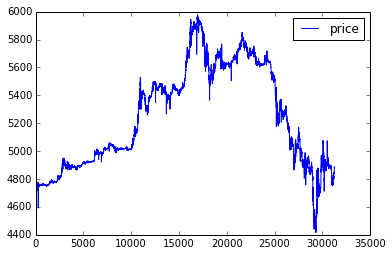

In [35]:
plt.plot(p.avgLine, label = 'price')
plt.legend()

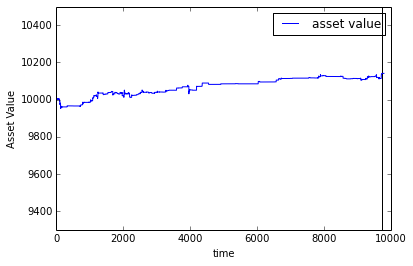

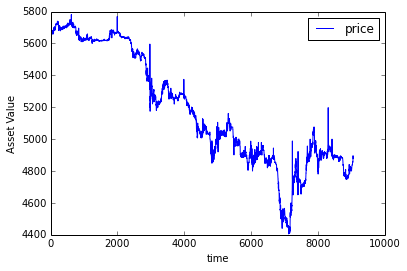

In [37]:
plt.plot(assetValue, label = 'asset value')
plt.legend()
index = np.argmax(assetValue)
plt.vlines(index,9300,10500)
plt.ylim([9300,10500])
plt.xlabel("time")
plt.ylabel("Asset Value")
plt.show()

plt.plot(buyTest['price'], label = 'price')
plt.legend()
index = np.argmax(assetValue)
plt.xlabel("time")
plt.ylabel("Asset Value")
plt.show()

In [44]:
testBuy = buyTest
testSell = buyTest
from scipy.stats import norm
assetValue = np.zeros(testBuy.shape[0]-40)
#norm.ppf(0.95, loc=0, scale=1)
def patternTrade(referencedata, referencesell,buyThreshold, initCash, shortSell = False, simiScore = 60):
    cash = initCash
    share = 0
    sellStk = []
    counter = 0.
    total = 0.
    for start in xrange(41,referencedata.shape[0]):
        idx = start
        assetValue[idx-40] = cash + share * referencedata['price'].iloc[idx]

        if start % 500 == 0: 
            if total != 0: print "accuracy ", counter/total
            print "iteration ", start
            print "cash ", cash
            print "share ", share
            print "asset value ", cash + share * referencedata['price'].iloc[idx]
        pattern = p.currentRecognition(start, 40)
        prediction = p.simPatternRecognition(simiScore, pattern)
        threshold = 0
        if len(prediction) != 0 and idx < referencedata.shape[0]:
            threshold = -np.mean(prediction) / (np.std(prediction)/np.sqrt(len(prediction)))
            #pred = np.mean(prediction) - np.std(prediction)/np.sqrt(len(prediction)) * buyThreshold
            #if (np.median(prediction) - buyThreshold)*(referencesell['price'].iloc[idx + 1] - referencesell['price'].iloc[idx]) >= 0:
                #counter += 1.
            threshold = norm.cdf(threshold)
            if (threshold - 0.3)* (referencesell['price'].iloc[idx + 1] - referencesell['price'].iloc[idx]) >= 0:
                counter += 1
            total += 1
        
        if len(sellStk) != 0:
            if idx == sellStk[-1]:
                sellStk.pop()
                dump = referencedata['size'].iloc[idx]
                if share >= dump:
                    share -= dump
                    cash += referencedata['price'].iloc[idx] * dump
                else:
                    cash += referencedata['price'].iloc[idx] * share
                    share = 0
                if share > 0:
                    sellStk.append(idx + 1)
        else:
            if threshold > 0.4:
            #if len(prediction) != 0 and np.median(prediction) > buyThreshold:
                get = min(1, threshold) * threshold * referencesell['size'].iloc[idx]
                if cash >= referencesell['price'].iloc[idx] * get:
                    cash -= referencesell['price'].iloc[idx] * get
                    share += get
                else:
                    share += cash / referencesell['price'].iloc[idx]
                    cash = 0
                sellStk.append(idx + 1)
            '''    
            elif threshold > 0.9:
            #if len(prediction) != 0 and np.median(prediction) > buyThreshold:
                get = 0.8 * referencesell['size'].iloc[idx]
                if cash >= referencesell['price'].iloc[idx] * get:
                    cash -= referencesell['price'].iloc[idx] * get
                    share += get
                else:
                    share += cash / referencesell['price'].iloc[idx]
                    cash = 0
                sellStk.append(idx + 1)
                
            elif threshold > 0.95:
            #if len(prediction) != 0 and np.median(prediction) > buyThreshold:
                get = referencesell['size'].iloc[idx]
                if cash >= referencesell['price'].iloc[idx] * get:
                    cash -= referencesell['price'].iloc[idx] * get
                    share += get
                else:
                    share += cash / referencesell['price'].iloc[idx]
                    cash = 0
                sellStk.append(idx + 1)
            '''
    #return assetValue              

In [63]:
patternTrade(testBuy, testSell, 1.645, 10000, shortSell = False, simiScore = 60)

(9000, 10500)

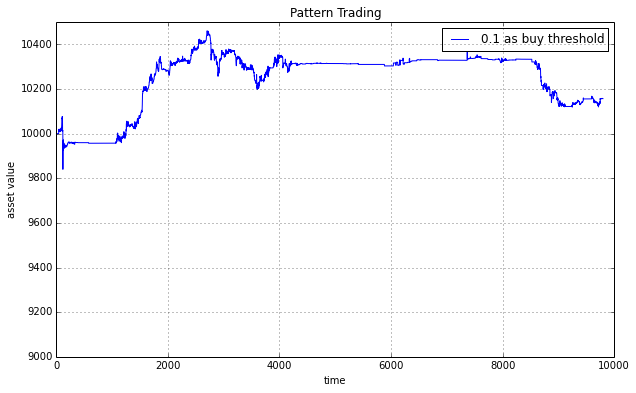

In [35]:
plt.figure(figsize = (10,6))
plt.plot(assetValue, label = '0.1 as buy threshold')
plt.xlabel("time")
plt.ylabel("asset value")
plt.title("Pattern Trading")
plt.legend(loc='best')
plt.grid(True)
plt.ylim([9000,10500])

(9000, 10500)

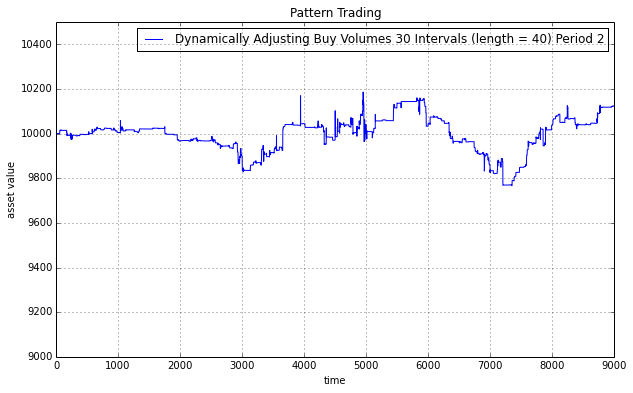

In [43]:
plt.figure(figsize = (10,6))
plt.plot(assetValue[assetValue != 0], label = 'Dynamically Adjusting Buy Volumes 30 Intervals (length = 40) Period 2')
plt.xlabel("time")
plt.ylabel("asset value")
plt.title("Pattern Trading")
plt.legend(loc='best')
plt.grid(True)
plt.ylim([9000,10500])